# Smoothing humidity measurements

There is a periodical noise component to the humidity measurements in the GH, due to a humidifying system being activated something like every $5$ minutes. In order to accuractely assess the effect of other varaibles on the indoors humidity, we would like to filter out the effect of the humidifying system.

### Get dependencies and data

In [83]:
# import dependencies
import os
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [84]:
# define relevant paths
home_path = os.path.dirname(os.getcwd())
data_path = home_path + '\\data\\'
plot_path = home_path + '\\plotting\\plots\\'

In [85]:
# get merged data
data = pd.read_csv(
    data_path + 'data_merged.csv',
    header=[0, 1],
    index_col=[0, 1, 2, 3]
)

# convert index.date col to datetime
#data.index = pd.to_datetime(data.index.values)
data.index = data.index.set_levels(
    levels=pd.to_datetime(data.index.get_level_values(3).values),
    level=3
)


In [86]:
# define X vars - we are only concerned with GH pressure and temperature
x_vars = [
    ('humidity', 'DC_GT101_GM101'),
    ('humidity', 'DC_GT102_GM102'),
    ('humidity', 'DC_GT103_GM103'),
    ('humidity', 'DC_GT104_GM104'),
    ('humidity', 'TA01_GT10X_GM10X'),
    ('humidity', 'TA01_GT401_GM401'),
    ('humidity', 'TA02_GT401_GM401'),
    ('humidity', 'DC_GT401_GM401'),
    ('humidity', 'SMHI')
]

In [87]:
# filter columns to keep only x_vars
data = data[x_vars].copy()
print('Number of NAs\n')
print(data.isna().sum())
print('\n\n')

# remove NANs
data = data.dropna(
    how='any', 
    subset=x_vars
)

# drop "humidity" from MultiIndex since all from there :)
data = data.droplevel(level=0, axis=1)
x_vars = [var[-1] for var in x_vars]

Number of NAs

category  sensor_ID       
humidity  DC_GT101_GM101      0
          DC_GT102_GM102      0
          DC_GT103_GM103      0
          DC_GT104_GM104      0
          TA01_GT10X_GM10X    0
          TA01_GT401_GM401    0
          TA02_GT401_GM401    0
          DC_GT401_GM401      0
          SMHI                0
dtype: int64





### Plot the problem

C:\Users\Oskar\AppData\Local\Temp\ipykernel_55108\2940534547.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  subset = data.loc[(2, 21)].copy()


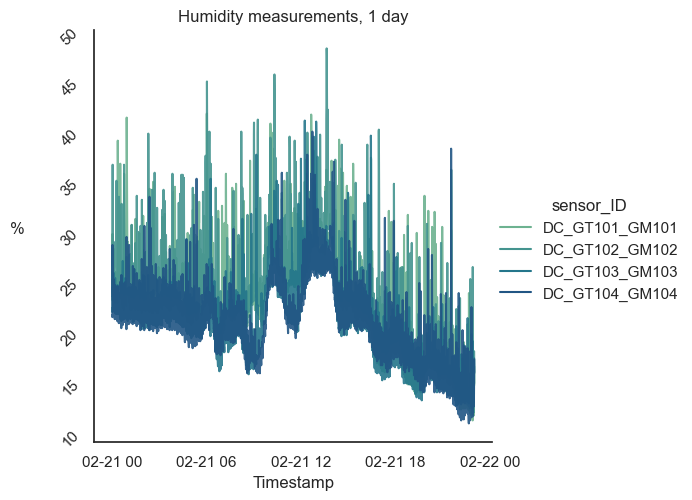

In [88]:
# set seaborn style/theme
sns.set_theme()
sns.set_style('white')

# create subset f. plotting, remove all date indices except DateTime
subset = data.loc[(2, 21)].copy()
subset = subset.droplevel(
    #level=[0, 1, 2], 
    level=0,
    axis=0
)

ax = sns.relplot(
    data=subset[x_vars[:4]], # only indoor sensors
    kind='line',
    palette='crest',
    alpha=0.9,
    dashes=False,
    markers=False,
    legend='full',
    linewidth=1.5
)

ax.set_xticklabels(step=2)

plt.yticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('%', loc='center', rotation=0, fontsize=12, labelpad=30)
plt.title('Humidity measurements, 1 day')

fpath = plot_path + 'humidity_1d.png'
plt.savefig(fpath, bbox_inches='tight', dpi=500)

plt.show()

### Moving average

We know that the short-term oscillations in humidity are due to a humidifying system in the GH which is activated every 5-ish minutes. Hence, it would seem to make sense to start by considering a moving average per $10$ steps, since we have two measurements per minute.

We consider the average of the four humidity sensors in the GH, i.e. TA01_GT10X_GM10X.

In [89]:
# remove day, hour, minute indices
data = data.droplevel(
    level=[0, 1, 2], 
    axis=0
)

# compute the rolling means using "pd.rolling", w. 10-step window and centered values
data['TA01_GT10X_GM10X_rolling'] = data.TA01_GT10X_GM10X.rolling(
    window=10,
    center=True
).mean().values

data['DC_GT401_GM401_rolling'] = data.DC_GT401_GM401.rolling(
    window=10,
    center=True,
).mean().values

data['SMHI_rolling'] = data.SMHI.rolling(
    window=10,
    center=True,
).mean().values

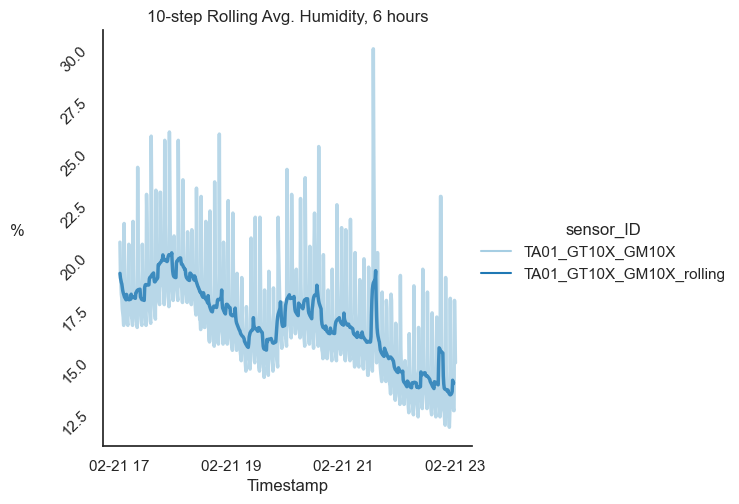

In [90]:
# define variable subset f. plotting
subset = [
    'TA01_GT10X_GM10X',
    'TA01_GT10X_GM10X_rolling'
].copy()

# plot as relplot
ax = sns.relplot(
    data=data[subset].iloc[-720:], # consider last 720 observations, i.e. 6 hrs.
    kind='line',
    palette='Paired',
    alpha=0.8,
    dashes=False,
    markers=False,
    legend='full',
    linewidth=2.5
)

ax.set_xticklabels(step=2)
plt.yticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('%', loc='center', rotation=0, fontsize=12, labelpad=30)
plt.title('10-step Rolling Avg. Humidity, 6 hours')

fpath = plot_path + 'rolling_humidity_6h.png'
plt.savefig(fpath, bbox_inches='tight', dpi=500)

plt.show()

### FFT Smoothing

Since we know that there is a periodical component to the data, we might try to smooth out the periodical fluctuations using the Fast Fourier Transform (FFT).

In [91]:
# perform FFT 
fourier = np.fft.rfft(data.TA01_GT10X_GM10X.values)

# get FREQS
spacing = 1 / 10 # i.e. 1/10th of cycle PER step, due to 5-min cycles.
#spacing = 1
freqs = np.fft.rfftfreq(
    n = len(data),
    d = spacing
)

# filter fourier series
threshold = 1
fourier[freqs > threshold] = 0
filtered1 = np.fft.irfft(fourier)

# perform inverse transform
threshold = 1 / 10
fourier[freqs > threshold] = 0
filtered2 = np.fft.irfft(fourier)

C:\Users\Oskar\AppData\Local\Temp\ipykernel_55108\3527801513.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TA01_GT10X_GM10X_fft1'].iloc[-28800:] = filtered1[-28800:]
C:\Users\Oskar\AppData\Local\Temp\ipykernel_55108\3527801513.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TA01_GT10X_GM10X_fft2'].iloc[-28800:] = filtered2[-28800:]


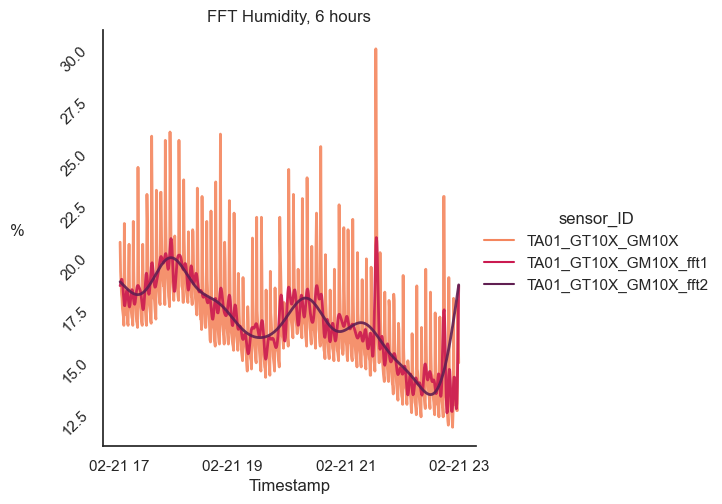

In [92]:
data['TA01_GT10X_GM10X_fft1'] = 0
data['TA01_GT10X_GM10X_fft2'] = 0
data['TA01_GT10X_GM10X_fft1'].iloc[-28800:] = filtered1[-28800:]
data['TA01_GT10X_GM10X_fft2'].iloc[-28800:] = filtered2[-28800:]

subset = [
    'TA01_GT10X_GM10X',
    'TA01_GT10X_GM10X_fft1',
    'TA01_GT10X_GM10X_fft2'
]

ax = sns.relplot(
    data=data[subset].iloc[-720:], # consider last 720 observations, i.e. 6 hrs.
    kind='line',
    palette='rocket_r',
    alpha=0.9,
    dashes=False,
    markers=False,
    legend='full',
    linewidth=2.0
)

ax.set_xticklabels(step=2)
plt.yticks(rotation=45)
plt.xlabel('Timestamp')
plt.ylabel('%', loc='center', rotation=0, fontsize=12, labelpad=30)
plt.title('FFT Humidity, 6 hours')

fpath = plot_path + 'fft_humidity_6h.png'
plt.savefig(fpath, bbox_inches='tight', dpi=500)

plt.show()

### Plot for last 5 days normalized values

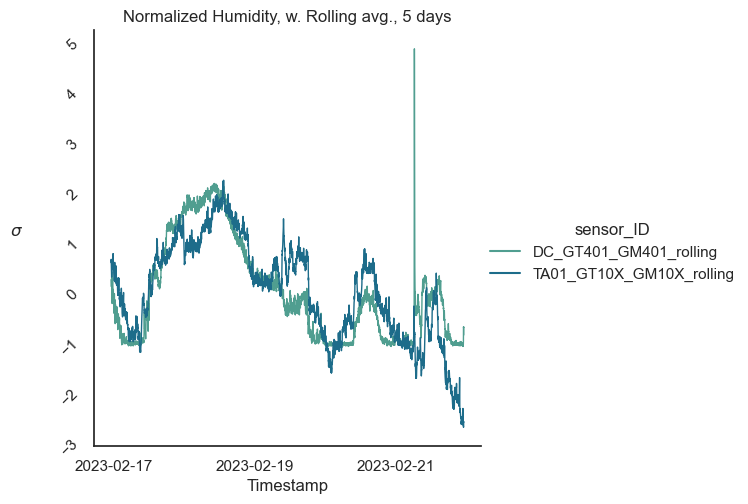

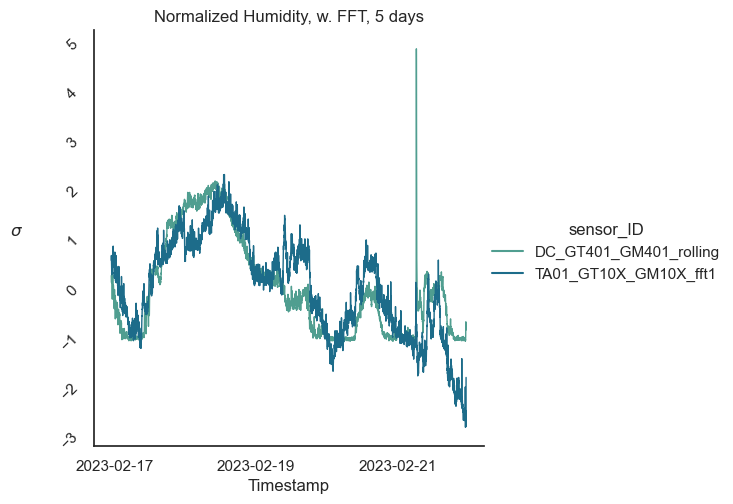

In [95]:
# make subset of data 
daydat = data.iloc[-14400:].copy() # only keep last 2880 vals, i.e. last 24 hrs

# normalize all cols
for col in daydat.columns:
    daydat[col] = (daydat[col]- daydat[col].mean()) / daydat[col].std()

subsets = [
    {
        'title':'Normalized Humidity, w. Rolling avg., 5 days',
        'fname':'norm_humid_rolling_5d.png',
        'vars': [
            'DC_GT401_GM401_rolling',
            'TA01_GT10X_GM10X_rolling',
            #'SMHI_rolling',
        ]
    },
    {
        'title':'Normalized Humidity, w. FFT, 5 days',
        'fname':'norm_humid_fft_5d.png',
        'vars': [
            'DC_GT401_GM401_rolling',
            'TA01_GT10X_GM10X_fft1',
            #'SMHI_rolling',
        ]
    }
]

for subset in subsets:
    ax = sns.relplot(
        data=daydat[subset['vars']], # consider last 720 observations, i.e. 6 hrs.
        kind='line',
        palette='crest',
        alpha=1.0,
        dashes=False,
        markers=False,
        legend='full',
        linewidth=1.0
    )

    ax.set_xticklabels(step=2)
    plt.yticks(rotation=45)
    plt.xlabel('Timestamp')
    plt.ylabel('$\sigma$', loc='center', rotation=0, fontsize=12, labelpad=30)
    plt.title(subset['title'])
    
    
    fpath = plot_path + subset['fname']
    plt.savefig(fpath, bbox_inches='tight', dpi=500)

    plt.show()
    